In [1]:
url_pay = 'https://raw.githubusercontent.com/serikovigor/ltv_calc/main/payments.csv'
url_prof = 'https://raw.githubusercontent.com/serikovigor/ltv_calc/main/profiles.csv'

# Тестовое задание на расчет LTV


In [180]:
import pandas as pd
import numpy as np


In [181]:
payments = pd.read_csv(url_pay)
payments[:3]

,uid,pay_dt,payment_sum
0,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-05,3.49
1,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-06,0.69
2,cb1ef3ef1e9c802076280e506142012b6158ab7ea91eb0...,2019-07-09,6.99


In [182]:
payments.dtypes

uid             object
pay_dt          object
payment_sum    float64
dtype: object

In [183]:
payments.shape, payments['uid'].unique().shape

((2712, 3), (521,))

In [184]:
profiles = pd.read_csv(url_prof)
profiles[:3]


,uid,reg_dt
0,1ef97d08f94722cc479b73df5c0218f5ba2c9404a1e93e...,2019-06-25
1,c9f16ccbf1bbc5c5ee2e446b11d0b1ff61a3f0956b4ae7...,2019-10-15
2,ec697f3d7cd7cbb584af5d3666d201c82e3a476362f907...,2019-05-14


In [185]:
profiles.shape

(5000, 2)

In [186]:
profiles['reg_dt'] = pd.to_datetime(profiles['reg_dt'],dayfirst = True)

In [187]:
pay_df = payments.merge(profiles,  how='left', left_on='uid', right_on='uid')

In [188]:
pay_df['reg_dt'] = pd.to_datetime(pay_df['reg_dt'],dayfirst = True)
pay_df['pay_dt'] = pd.to_datetime(pay_df['pay_dt'],dayfirst = True)

In [189]:
pay_df = pay_df.sort_values('pay_dt')

In [190]:
pay_df.dtypes

uid                    object
pay_dt         datetime64[ns]
payment_sum           float64
reg_dt         datetime64[ns]
dtype: object

In [192]:
## Кол-во дней с даты регистрацции, определяет день LTV
pay_df['day'] = pd.to_timedelta(pay_df['pay_dt'] - pay_df['reg_dt']).dt.days + 1
pay_df['day'] = pay_df['day'].astype(int)

In [193]:
pay_df = pay_df[[c for c in pay_df if c not in ['uid']] + ['uid']]

In [194]:
pay_df[:3]

,pay_dt,payment_sum,reg_dt,day,uid
156,2019-04-15,3.40,2019-04-15,1,8ef4803d7a41e8b2164e77a06b4c67650806572218ccd4...
157,2019-04-16,0.68,2019-04-15,2,8ef4803d7a41e8b2164e77a06b4c67650806572218ccd4...
1775,2019-04-16,11.14,2019-04-16,1,700784adfdd162b4fd53c496196c10badf17c4b847f25f...


# 1 пункт
построим LTV для всех когорт (дней)

In [195]:
df = pay_df
from_date = '2019-04-15'
df = df[df['reg_dt']>=from_date]
df['day'] = pd.to_timedelta(df['pay_dt'] - df['reg_dt']).dt.days + 1
df['day'] = df['day'].astype(int)

In [196]:
def LTV_for_day(df, day):
    ''' df - DataFrame, day - LTV day number'''
    df_day = df[df['day']<=day]
    df_day_uniq = len(df_day['uid'].unique())
    df_day_sum = df_day['payment_sum'].sum()
    ltv = df_day_sum / df_day_uniq
    return ltv

In [197]:
ltv_arr = []
for n in range(0,180):
    ltv_arr.append(LTV_for_day(df,n))

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'LTV')

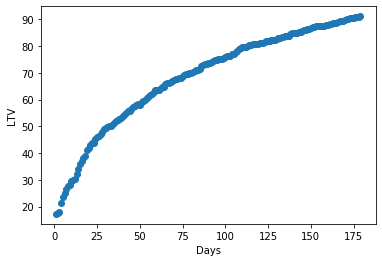

In [198]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(list(range(0,180)),ltv_arr)
plt.xlabel('Days')
plt.ylabel('LTV')

#### Как видно, ltv - можно аппроксимировать линейной функцией.
Поэтому рассчитав коэффициент LTV_K_90_5 = LTV_AVG_90/LTV_AVG_5,
можно потом восстановить  даже по одной точке LTV_AVG_5.


## 2 пункт

In [199]:
def LTV_90_5_ratio(df, from_date):
    df = df[df['reg_dt']>=from_date].copy()
    df['day'] = pd.to_timedelta(df['pay_dt'] - df['reg_dt']).dt.days + 1
    df['day'] = df['day'].astype(int)
    return LTV_for_day(df, 90) / LTV_for_day(df, 5),LTV_for_day(df, 90), LTV_for_day(df, 5)
    
    
    

In [200]:
k90_5, LTV90_, LTV_5_ = LTV_90_5_ratio(pay_df, '2019-05-01')

In [201]:
# установленный коэффициент
k90_5

3.0441181921459877

In [202]:
k, LTV90, LTV5 = LTV_90_5_ratio(pay_df, '2019-09-01')

In [203]:
print (k, LTV90, LTV5)

3.1541919586524045 86.91027027027027 27.553893805309738


In [204]:
#Реальное LTV90
print ('REAL LTV90', LTV90)
print ('calc LTV90', LTV5*k90_5)

REAL LTV90 86.91027027027027
calc LTV90 83.87730939720201


### Как видно ошибка восстановления - не большая